#Link to dataset: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
Ack: this notebook contains some functions/code logics used in https://www.kaggle.com/code/rattttttttttt/mnist-ocr-cnn-vs-ann-vs-resnet with some modification for classroom activity

Source: https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80
<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*A8cX1eHqGI7dIuH3awcjlw.jpeg" width="100%">'


#Lets set up our environment

In [50]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Create train and test dataloader

In [51]:
# Transform to tensor
#transform = transforms.Compose([transforms.ToTensor()])
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
# Download and load MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(f'Train loader - {len(train_loader)}')
print(f'Test loader - {len(test_loader)}')
# Show one batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)

Train loader - 938
Test loader - 157
Batch shape: torch.Size([64, 1, 28, 28])


torch.Size([1, 28, 28])


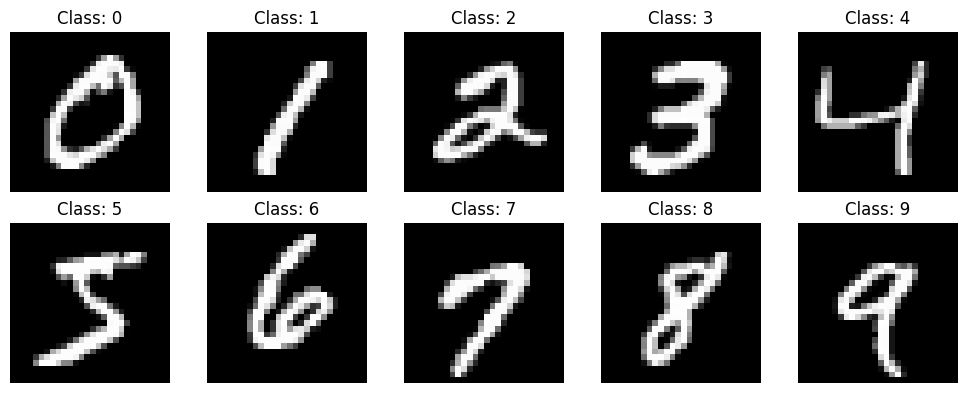

In [52]:
def visualize_one_per_class():
    samples = {}
    for img, label in train_data:
        if label not in samples:
            samples[label] = img
        if len(samples) == 10:
            break
    print(samples[0].shape)

    fig = plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(samples[i].squeeze(), cmap="gray")
        plt.title(f"Class: {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_one_per_class()

# Load pretrained MobileNetV3 and modify for your own classification task

In [53]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# Load pretrained MobileNetV3 Small
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

# Modify input/output layers
model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 10)

# Example: move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [54]:
def train_model(model, train_loader, test_loader, epochs=1):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_id, data in enumerate(train_loader):
            images, labels = data[0], data[1]
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()
            if batch_id%100==0: #print every 100th batch
              print(f'Train loss = {loss} at {batch_id}th batch')
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_accs.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = correct / total
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {np.mean(train_losses).item():.4f}, Train Acc: {train_acc:.4f}, "
              f"Test Loss: {np.mean(test_losses).item():.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accs, test_losses, test_accs

train_losses_cnn, train_accs_cnn, test_losses_cnn, test_accs_cnn = train_model(model, train_loader, test_loader)

Train loss = 2.9280734062194824 at 0th batch
Train loss = 2.2289862632751465 at 100th batch
Train loss = 1.386759877204895 at 200th batch
Train loss = 1.3663841485977173 at 300th batch
Train loss = 1.221645474433899 at 400th batch
Train loss = 0.7625567317008972 at 500th batch
Train loss = 0.5949923992156982 at 600th batch
Train loss = 0.7420215010643005 at 700th batch
Train loss = 1.120456337928772 at 800th batch
Train loss = 0.49396923184394836 at 900th batch
Epoch 1/1: Train Loss: 1.1600, Train Acc: 0.6192, Test Loss: 0.4942, Test Acc: 0.8393


#Lets plot the train/test accuracy and loss curves

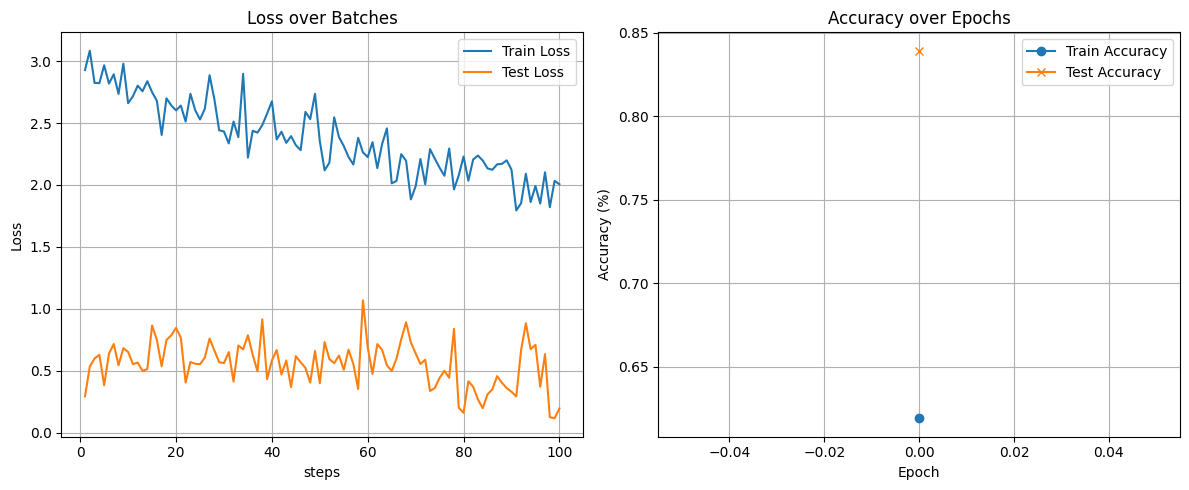

In [59]:
steps = range(1, len(train_losses_cnn[:100]) + 1)

plt.figure(figsize=(12,5))

# --- Loss curves ---
plt.subplot(1, 2, 1)
plt.plot(steps, train_losses_cnn[:100], '-', label='Train Loss')
plt.plot(steps, test_losses_cnn[:100], '-', label='Test Loss')
plt.title('Loss over Batches')
plt.xlabel('steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Accuracy curves ---
plt.subplot(1, 2, 2)
plt.plot(train_accs_cnn, 'o-', label='Train Accuracy')
plt.plot(test_accs_cnn, 'x-', label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Lets test a single sample

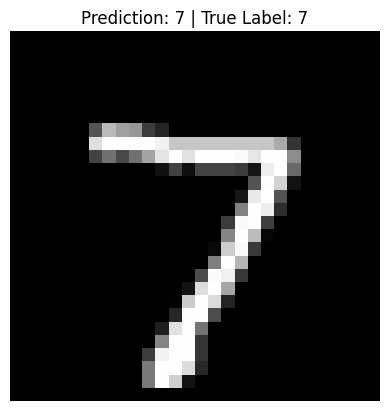

In [60]:
# --- Get one test sample ---
images, labels = next(iter(test_loader))
image = images[0]
label = labels[0].item()

# --- Send to device and predict ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0).to(device))
    pred = output.argmax(dim=1).item()

# --- Plot image with prediction ---
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Prediction: {pred} | True Label: {label}")
plt.axis('off')
plt.show()